In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from collections import defaultdict

In [2]:
accounts = pd.read_csv('Accounts.csv')
accounts_properties = pd.read_csv('Accounts_properties.csv')
deals_to_properties = pd.read_csv('Deals_to_Properties.csv')
opportunities = pd.read_csv('Opportunities.csv')
properties = pd.read_csv('Properties.csv')
test = pd.read_csv('Test_Data.csv')

In [3]:
accounts.head()

,id_accs,active_deals,activity_count,buyer_book,servicing_contract,investor_type,cmbs,consultant,correspondent,foreign,master_servicer,lender_book,loan_sales_book,loan_servicing,num_deals_as_client,num_deals_as_investor,number_of_properties,number_of_related_deals,number_of_related_properties,number_of_won_deals_as_client
0,0012A000023XlCCQA0,1,2367,True,False,Private Investor/Developer,False,False,False,False,False,False,False,False,0,1,1,2,1,0
1,0012A000023XmOxQAK,9,7974,True,False,REIT,False,False,False,False,False,True,True,False,7,2,77,18,85,7
2,0012A000023YLqwQAG,891,50161,True,True,Bank / Thrift,False,False,False,False,False,True,True,False,40,851,693,996,1167,37
3,0012A000023XlNjQAK,34,14631,True,False,Conduit/CMBS,True,False,False,True,False,True,True,False,0,34,0,45,14,0
4,0012A000023YBFRQA4,283,194195,True,False,Life Insurance Company,False,False,False,False,False,True,True,False,63,220,393,383,591,46


In [4]:
accounts.investor_type.fillna('X', inplace=True)

In [5]:
accounts.isnull().any()

id_accs                          False
active_deals                     False
activity_count                   False
buyer_book                       False
servicing_contract               False
investor_type                    False
cmbs                             False
consultant                       False
correspondent                    False
foreign                          False
master_servicer                  False
lender_book                      False
loan_sales_book                  False
loan_servicing                   False
num_deals_as_client              False
num_deals_as_investor            False
number_of_properties             False
number_of_related_deals          False
number_of_related_properties     False
number_of_won_deals_as_client    False
dtype: bool

In [6]:
accounts_properties.head()

,id,id_deals,id_accs,id_props
0,a062A00001Whq5tQAB,a062A00001Whq5tQAB,0012A000023XlCCQA0,a0I2A00000XQKwXUAX
1,a062A00001VmP7EQAV,a062A00001VmP7EQAV,0012A000023XmOxQAK,a0I2A00000XvUEwUAN
2,a062A00001VmQByQAN,a062A00001VmQByQAN,0012A000023XmOxQAK,a0I2A00000XwQ13UAF
3,a062A00001VmQC2QAN,a062A00001VmQC2QAN,0012A000023XmOxQAK,a0I2A00000XwZyBUAV
4,a062A00001VmW8wQAF,a062A00001VmW8wQAF,0012A000023XmOxQAK,a0I2A00000ZGZClUAP


In [7]:
accounts_properties.isnull().any()

id          False
id_deals    False
id_accs     False
id_props    False
dtype: bool

In [8]:
accounts_properties.id_props.nunique()

63001

In [9]:
accounts_properties.shape

(70350, 4)

In [10]:
deals_to_properties.head()

,id,createdbyid,id_deals,id_props
0,a0A2A00000TxIrIUAV,005F0000007WnNDIA0,0062A00000o979GQAQ,a0I2A00000XQH8YUAX
1,a0A2A00000TxIrSUAV,005F0000007WnNDIA0,0062A00000o94JrQAI,a0I2A00000XQJ4dUAH
2,a0A2A00000TxIrXUAV,005F0000007WnNDIA0,0062A00000o94GJQAY,a0I2A00000XQJL0UAP
3,a0A2A00000TxIrcUAF,005F0000007WnNDIA0,0062A00000o982fQAA,a0I2A00000XQKgkUAH
4,a0A2A00000TxIrhUAF,005F0000007WnNDIA0,0062A00000o96M4QAI,a0I2A00000XQMEhUAP


In [11]:
deals_to_properties.shape

(25820, 4)

In [12]:
opportunities.head()

,id_deals,id_accs,accounting_date,best_initial_bid,id_deals.1,closedate,date_closed,deal_type,deal_update_flag,debt_yield,fiscal,fiscalquarter,fiscalyear,platform,property_group,property_type
0,0062A00000moF1LQAU,0012A000023XvIOQA0,NaN,NaN,0062A00000moF1LQAU,8/12/2005,8/18/2005 0:00,Fixed-rate,True,NaN,2005 3,3,2005,Debt,Healthcare,Healthcare
1,0062A00000moF9LQAU,0012A000023YFe1QAG,NaN,NaN,0062A00000moF9LQAU,2/6/2012,6/27/2012 12:00,Fixed-rate,True,NaN,2012 1,1,2012,Debt,Healthcare,Biotech
2,0062A00000moGodQAE,0012A000023YEDcQAO,8/12/2004,NaN,0062A00000moGodQAE,11/24/2003,8/11/2004 0:00,Construction Loan,True,NaN,2003 4,4,2003,Debt,Healthcare,Biotech
3,0062A00000moBTHQA2,0012A000023YA3nQAG,NaN,NaN,0062A00000moBTHQA2,2/10/2006,4/19/2006 0:00,Fixed-rate,True,NaN,2006 1,1,2006,Debt,Healthcare,Healthcare
4,0062A00000mo8OjQAI,0012A000023XpRUQA0,NaN,NaN,0062A00000mo8OjQAI,7/13/2006,11/16/2006 0:00,Fixed-rate,True,NaN,2006 3,3,2006,Debt,Healthcare,Healthcare


In [13]:
properties.head()

,id_props,building_status,building_tax_expenses,id_deals,city,class,county,sale_status,portfolio,market,...,price_per_sq_ft,price_per_unit,property_type_1,region__c,sale_amount__c,sale_date__c,size_acres,size_sf,size_units,year_built
0,a0I2A00000XQGKlUAP,Existing,2009 Tax @ $1.25/sf,a0I2A00000XQGKlUAP,City-0488,Class B,County-0172,N,False,Market-0059,...,46.59,18350000.00,Industrial,Southwest,1.835000e+07,7/10/2015,3.760,393862.0,1.0,1980.0
1,a0I2A00000XQGKnUAP,NaN,NaN,a0I2A00000XQGKnUAP,City-1975,Class A,County-0465,Y,True,Market-0239,...,1141.55,2109090.91,Multi-Housing,Southeast,2.144058e+07,12/31/2016,19.600,508080.0,275.0,2014.0
2,a0I2A00000XQGKoUAP,Existing,"2016 Tax @ $5.63/sf; 2007 Ops @ $19.58/sf, 201...",a0I2A00000XQGKoUAP,City-1415,Class B,County-0452,N,False,Market-0165,...,1506.65,NaN,Retail,Northeast,2.754156e+07,9/30/2016,0.266,18280.0,NaN,1902.0
3,a0I2A00000XQGKpUAP,NaN,NaN,a0I2A00000XQGKpUAP,City-1415,Class A,County-0452,N,False,Market-0165,...,580.83,1220689.66,NaN,Northeast,1.416000e+08,1/21/2016,0.530,243789.0,116.0,NaN
4,a0I2A00000XQGKqUAP,NaN,NaN,a0I2A00000XQGKqUAP,City-0941,NaN,County-0284,N,False,Market-0106,...,NaN,NaN,Self-Storage,Southwest,0.000000e+00,9/30/2014,NaN,NaN,NaN,NaN


In [14]:
properties.isnull().sum()

id_props                     0
building_status           8217
building_tax_expenses     8743
id_deals                     0
city                         0
class                     6948
county                       0
sale_status                193
portfolio                    0
market                       1
num_buildings             7550
num_floors                4672
num_parking_spaces       10468
occupancy_rate            4052
price_per_sq_ft           6437
price_per_unit           12621
property_type_1            311
region__c                    5
sale_amount__c            6440
sale_date__c              6093
size_acres                4354
size_sf                   1568
size_units               10059
year_built                1858
dtype: int64

In [15]:
properties.shape

(18298, 24)

In [16]:
properties.building_status.value_counts()
properties.building_status.fillna('Unknown', inplace=True)

In [17]:
properties.building_tax_expenses.value_counts()
properties.drop(['building_tax_expenses'], axis = 1,  inplace=True)

In [18]:
properties['class'].value_counts()
properties['class'].fillna('Unknown', inplace = True)

In [19]:
properties.sale_status.value_counts()
properties.sale_status.fillna('Unknown', inplace=True)

In [20]:
properties.market.value_counts()
properties.market.fillna('Market-0059', inplace=True)

In [21]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.stats import norm, skew
# fig, ax = plt.subplots()
# sns.distplot(properties['num_buildings'].dropna() , fit = norm)
# plt.show()
#properties.num_buildings.value_counts()
properties[properties.num_buildings > 40].shape
properties.loc[properties['num_buildings'] > 40, 'num_buildings'] = 40
properties.num_buildings.describe()
properties.num_buildings.fillna(1, inplace=True)

In [22]:
properties.num_floors.describe()
properties.num_floors.fillna(2, inplace=True)
properties[properties.num_floors > 20].shape
properties.loc[properties['num_floors'] > 20, 'num_floors'] = 20

In [23]:
properties.num_parking_spaces.describe()
properties.num_parking_spaces.fillna(300, inplace=True)
properties[properties.num_parking_spaces > 1000].shape
properties.loc[properties['num_parking_spaces'] > 1000, 'num_parking_spaces'] = 1000

In [24]:
properties.occupancy_rate.describe()
properties.occupancy_rate.fillna(100, inplace=True)

In [25]:
properties.price_per_sq_ft.describe()
properties[properties.price_per_sq_ft > 5000].shape
properties.loc[properties['price_per_sq_ft'] > 5000, 'price_per_sq_ft'] = 5000
properties.price_per_sq_ft.fillna(600, inplace=True)

In [26]:
properties.price_per_unit.describe()
properties[properties.price_per_unit > 800000].shape
properties.loc[properties['price_per_unit'] > 800000, 'price_per_unit'] = 800000
properties.price_per_unit.fillna(300000, inplace=True)

In [27]:
properties.property_type_1.value_counts()
properties.property_type_1.fillna('Unknown', inplace=True)

In [28]:
properties.region__c.value_counts()
properties.region__c.fillna('Southwest', inplace=True)

In [29]:
properties.sale_amount__c.describe()
properties[properties.sale_amount__c > 800000000].shape
properties.loc[properties['sale_amount__c'] > 800000000, 'sale_amount__c'] = 800000000
properties.sale_amount__c.fillna(7.051615e+07, inplace=True)

In [30]:
properties.drop(['sale_date__c'], axis = 1, inplace=True)

In [31]:
properties.size_acres.describe()
properties[properties.size_acres > 40].shape
properties.loc[properties['size_acres'] > 40, 'size_acres'] = 40
properties.size_acres.fillna(9, inplace=True)

In [32]:
properties.size_sf.describe()
properties.size_sf.fillna(1.892048e+05, inplace=True)

In [33]:
properties.size_units.describe()
properties[properties.size_units > 700].shape
properties.loc[properties['size_units'] > 700, 'size_units'] = 700
properties.size_units.fillna(218, inplace=True)

In [34]:
properties.size_units.describe()

count    18298.000000
mean       218.388403
std        119.758298
min          0.000000
25%        212.000000
50%        218.000000
75%        218.000000
max        700.000000
Name: size_units, dtype: float64

In [35]:
properties.year_built.value_counts()
properties[properties['year_built'] < 1830].shape
properties.loc[properties['year_built'] < 1800, 'year_built'] = 1986
properties.year_built.fillna(1985, inplace=True)

In [36]:
properties.isnull().sum()

id_props              0
building_status       0
id_deals              0
city                  0
class                 0
county                0
sale_status           0
portfolio             0
market                0
num_buildings         0
num_floors            0
num_parking_spaces    0
occupancy_rate        0
price_per_sq_ft       0
price_per_unit        0
property_type_1       0
region__c             0
sale_amount__c        0
size_acres            0
size_sf               0
size_units            0
year_built            0
dtype: int64

In [37]:
properties.info()
properties_id = properties['id_props']
properties_deals = properties['id_deals']
properties.drop(['id_props', 'id_deals'], axis = 1, inplace= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18298 entries, 0 to 18297
Data columns (total 22 columns):
id_props              18298 non-null object
building_status       18298 non-null object
id_deals              18298 non-null object
city                  18298 non-null object
class                 18298 non-null object
county                18298 non-null object
sale_status           18298 non-null object
portfolio             18298 non-null bool
market                18298 non-null object
num_buildings         18298 non-null float64
num_floors            18298 non-null float64
num_parking_spaces    18298 non-null float64
occupancy_rate        18298 non-null float64
price_per_sq_ft       18298 non-null float64
price_per_unit        18298 non-null float64
property_type_1       18298 non-null object
region__c             18298 non-null object
sale_amount__c        18298 non-null float64
size_acres            18298 non-null float64
size_sf               18298 non-null float64
size

In [38]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18298 entries, 0 to 18297
Data columns (total 20 columns):
building_status       18298 non-null object
city                  18298 non-null object
class                 18298 non-null object
county                18298 non-null object
sale_status           18298 non-null object
portfolio             18298 non-null bool
market                18298 non-null object
num_buildings         18298 non-null float64
num_floors            18298 non-null float64
num_parking_spaces    18298 non-null float64
occupancy_rate        18298 non-null float64
price_per_sq_ft       18298 non-null float64
price_per_unit        18298 non-null float64
property_type_1       18298 non-null object
region__c             18298 non-null object
sale_amount__c        18298 non-null float64
size_acres            18298 non-null float64
size_sf               18298 non-null float64
size_units            18298 non-null float64
year_built            18298 non-null float64
dt

In [39]:
for c in properties.columns:
    print(c, properties[c].nunique(), properties[c].dtype)

building_status 5 object
city 2343 object
class 4 object
county 708 object
sale_status 3 object
portfolio 2 bool
market 257 object
num_buildings 41 float64
num_floors 21 float64
num_parking_spaces 876 float64
occupancy_rate 100 float64
price_per_sq_ft 9916 float64
price_per_unit 4289 float64
property_type_1 12 object
region__c 6 object
sale_amount__c 4467 float64
size_acres 6486 float64
size_sf 14278 float64
size_units 634 float64
year_built 162 float64


In [40]:
properties.drop(['city', 'county', 'market'], axis = 1, inplace=True)
properties2 = pd.get_dummies(properties, drop_first=True)

In [41]:
properties2.portfolio = np.where(properties.portfolio == False, 0, 1)

In [42]:
properties2.head()

,portfolio,num_buildings,num_floors,num_parking_spaces,occupancy_rate,price_per_sq_ft,price_per_unit,sale_amount__c,size_acres,size_sf,...,property_type_1_Other,property_type_1_Retail,property_type_1_Self-Storage,property_type_1_Seniors Housing,property_type_1_Unknown,region__c_Midwest,region__c_Northeast,region__c_Southeast,region__c_Southwest,region__c_West
0,0,1.0,1.0,56.0,95.0,46.59,800000.0,1.835000e+07,3.760,393862.0,...,0,0,0,0,0,0,0,0,1,0
1,1,1.0,2.0,300.0,100.0,1141.55,800000.0,2.144058e+07,19.600,508080.0,...,0,0,0,0,0,0,0,1,0,0
2,0,1.0,6.0,300.0,100.0,1506.65,300000.0,2.754156e+07,0.266,18280.0,...,0,1,0,0,0,0,1,0,0,0
3,0,1.0,20.0,300.0,100.0,580.83,800000.0,1.416000e+08,0.530,243789.0,...,0,0,0,0,1,0,1,0,0,0
4,0,1.0,2.0,300.0,100.0,600.00,300000.0,0.000000e+00,9.000,189204.8,...,0,0,1,0,0,0,0,0,1,0


In [43]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
properties3 = min_max.fit_transform(properties2)

In [44]:
properties3 = pd.DataFrame(properties3)

In [45]:
properties3.columns = properties2.columns

In [46]:
properties3.loc[:5000,].head()

,portfolio,num_buildings,num_floors,num_parking_spaces,occupancy_rate,price_per_sq_ft,price_per_unit,sale_amount__c,size_acres,size_sf,...,property_type_1_Other,property_type_1_Retail,property_type_1_Self-Storage,property_type_1_Seniors Housing,property_type_1_Unknown,region__c_Midwest,region__c_Northeast,region__c_Southeast,region__c_Southwest,region__c_West
0,0.0,0.025,0.05,0.055055,0.95,0.009318,1.000,0.022937,0.116098,0.010194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.025,0.10,0.299299,1.00,0.228310,1.000,0.026801,0.502439,0.013150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.025,0.30,0.299299,1.00,0.301330,0.375,0.034427,0.030878,0.000473,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.025,1.00,0.299299,1.00,0.116166,1.000,0.177000,0.037317,0.006310,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.025,0.10,0.299299,1.00,0.120000,0.375,0.000000,0.243902,0.004897,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
properties3.loc[:5000,].shape

(5001, 37)

In [48]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [49]:
data_dist = pdist(properties3.loc[20:60, ]) # computing the distance
data_link = linkage(data_dist) # computing the linkage

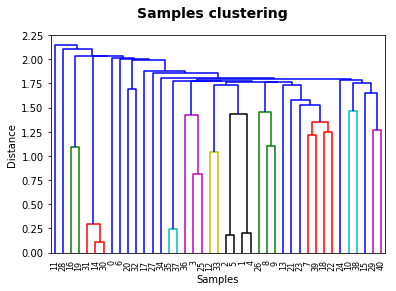

In [50]:
dendrogram(data_link)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14);


In [51]:
del(data_dist, data_link)

In [52]:
from sklearn.cluster import KMeans

In [53]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(properties3)

In [54]:
kmeans.labels_

array([0, 3, 7, ..., 3, 3, 9], dtype=int32)

In [55]:
kmeans.predict(properties3.loc[1:2,])

array([3, 7], dtype=int32)

In [56]:
properties3['cluster'] = kmeans.predict(properties3)

In [57]:
properties3['id_props'] = properties_id
properties3['id_deals'] = properties_deals

In [58]:
properties3.head()

,portfolio,num_buildings,num_floors,num_parking_spaces,occupancy_rate,price_per_sq_ft,price_per_unit,sale_amount__c,size_acres,size_sf,...,property_type_1_Seniors Housing,property_type_1_Unknown,region__c_Midwest,region__c_Northeast,region__c_Southeast,region__c_Southwest,region__c_West,cluster,id_props,id_deals
0,0.0,0.025,0.05,0.055055,0.95,0.009318,1.000,0.022937,0.116098,0.010194,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,a0I2A00000XQGKlUAP,a0I2A00000XQGKlUAP
1,1.0,0.025,0.10,0.299299,1.00,0.228310,1.000,0.026801,0.502439,0.013150,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,a0I2A00000XQGKnUAP,a0I2A00000XQGKnUAP
2,0.0,0.025,0.30,0.299299,1.00,0.301330,0.375,0.034427,0.030878,0.000473,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7,a0I2A00000XQGKoUAP,a0I2A00000XQGKoUAP
3,0.0,0.025,1.00,0.299299,1.00,0.116166,1.000,0.177000,0.037317,0.006310,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6,a0I2A00000XQGKpUAP,a0I2A00000XQGKpUAP
4,0.0,0.025,0.10,0.299299,1.00,0.120000,0.375,0.000000,0.243902,0.004897,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9,a0I2A00000XQGKqUAP,a0I2A00000XQGKqUAP


In [59]:
accounts_properties.head()

,id,id_deals,id_accs,id_props
0,a062A00001Whq5tQAB,a062A00001Whq5tQAB,0012A000023XlCCQA0,a0I2A00000XQKwXUAX
1,a062A00001VmP7EQAV,a062A00001VmP7EQAV,0012A000023XmOxQAK,a0I2A00000XvUEwUAN
2,a062A00001VmQByQAN,a062A00001VmQByQAN,0012A000023XmOxQAK,a0I2A00000XwQ13UAF
3,a062A00001VmQC2QAN,a062A00001VmQC2QAN,0012A000023XmOxQAK,a0I2A00000XwZyBUAV
4,a062A00001VmW8wQAF,a062A00001VmW8wQAF,0012A000023XmOxQAK,a0I2A00000ZGZClUAP


In [60]:
properties4 = pd.merge(left = accounts_properties, right=properties3, how = 'left', on = ['id_props'])

In [61]:
accounts_properties.shape

(70350, 4)

In [62]:
properties3.shape

(18298, 40)

In [63]:
properties4.shape

(70350, 43)

In [64]:
properties4.columns

Index(['id', 'id_deals_x', 'id_accs', 'id_props', 'portfolio', 'num_buildings',
       'num_floors', 'num_parking_spaces', 'occupancy_rate', 'price_per_sq_ft',
       'price_per_unit', 'sale_amount__c', 'size_acres', 'size_sf',
       'size_units', 'year_built', 'building_status_Existing',
       'building_status_Proposed', 'building_status_Under Construction',
       'building_status_Unknown', 'class_Class B', 'class_Class C',
       'class_Unknown', 'sale_status_Unknown', 'sale_status_Y',
       'property_type_1_Hotel-Lodging', 'property_type_1_Industrial',
       'property_type_1_Land', 'property_type_1_Medical Office Building',
       'property_type_1_Multi-Housing', 'property_type_1_Office',
       'property_type_1_Other', 'property_type_1_Retail',
       'property_type_1_Self-Storage', 'property_type_1_Seniors Housing',
       'property_type_1_Unknown', 'region__c_Midwest', 'region__c_Northeast',
       'region__c_Southeast', 'region__c_Southwest', 'region__c_West',
       'clust

In [65]:
properties4.drop(['id_deals_x', 'id_deals_y'], axis = 1, inplace=True)

In [69]:
properties3.head()

,portfolio,num_buildings,num_floors,num_parking_spaces,occupancy_rate,price_per_sq_ft,price_per_unit,sale_amount__c,size_acres,size_sf,...,property_type_1_Seniors Housing,property_type_1_Unknown,region__c_Midwest,region__c_Northeast,region__c_Southeast,region__c_Southwest,region__c_West,cluster,id_props,id_deals
0,0.0,0.025,0.05,0.055055,0.95,0.009318,1.000,0.022937,0.116098,0.010194,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,a0I2A00000XQGKlUAP,a0I2A00000XQGKlUAP
1,1.0,0.025,0.10,0.299299,1.00,0.228310,1.000,0.026801,0.502439,0.013150,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,a0I2A00000XQGKnUAP,a0I2A00000XQGKnUAP
2,0.0,0.025,0.30,0.299299,1.00,0.301330,0.375,0.034427,0.030878,0.000473,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7,a0I2A00000XQGKoUAP,a0I2A00000XQGKoUAP
3,0.0,0.025,1.00,0.299299,1.00,0.116166,1.000,0.177000,0.037317,0.006310,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6,a0I2A00000XQGKpUAP,a0I2A00000XQGKpUAP
4,0.0,0.025,0.10,0.299299,1.00,0.120000,0.375,0.000000,0.243902,0.004897,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9,a0I2A00000XQGKqUAP,a0I2A00000XQGKqUAP


In [78]:
properties3.shape
properties3.id_props.nunique()

18298

In [67]:
properties4.shape[0] - properties4.dropna().shape[0]

49485

In [68]:
test.head()

,id_accs
0,0012A00002AXHJUQA5
1,0012A000023XlWaQAK
2,0012A000023Y4bYQAS
3,0012A000023XlbuQAC
4,0012A000023Xlh9QAC


In [69]:
"0012A000023Xlh9QAC" in opportunities.values

False

In [70]:
properties4.head()

,id,id_accs,id_props,portfolio,num_buildings,num_floors,num_parking_spaces,occupancy_rate,price_per_sq_ft,price_per_unit,...,property_type_1_Retail,property_type_1_Self-Storage,property_type_1_Seniors Housing,property_type_1_Unknown,region__c_Midwest,region__c_Northeast,region__c_Southeast,region__c_Southwest,region__c_West,cluster
0,a062A00001Whq5tQAB,0012A000023XlCCQA0,a0I2A00000XQKwXUAX,0.0,0.025,0.1,0.299299,1.0,1.000000,0.345686,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0
1,a062A00001VmP7EQAV,0012A000023XmOxQAK,a0I2A00000XvUEwUAN,0.0,0.025,0.3,0.574575,0.7,0.060834,0.321782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,a062A00001VmQByQAN,0012A000023XmOxQAK,a0I2A00000XwQ13UAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a062A00001VmQC2QAN,0012A000023XmOxQAK,a0I2A00000XwZyBUAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,a062A00001VmW8wQAF,0012A000023XmOxQAK,a0I2A00000ZGZClUAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
properties4.shape

(70350, 41)

In [72]:
properties4['user_count'] = properties4.groupby(['id_accs'])['id_accs'].transform('count')

In [73]:
properties4['property_count'] = properties4.groupby(['id_props'])['id_props'].transform('count')

In [74]:
test.head(10)

,id_accs
0,0012A00002AXHJUQA5
1,0012A000023XlWaQAK
2,0012A000023Y4bYQAS
3,0012A000023XlbuQAC
4,0012A000023Xlh9QAC
5,0012A000023XlhdQAC
6,0012A000023XlkNQAS
7,0012A000023XlnWQAS
8,0012A000023XlnqQAC
9,0012A000023Xp5LQAS


In [75]:
for i in test.id_accs:
    print( i in accounts.values)


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [79]:
properties3.head()

,portfolio,num_buildings,num_floors,num_parking_spaces,occupancy_rate,price_per_sq_ft,price_per_unit,sale_amount__c,size_acres,size_sf,...,property_type_1_Seniors Housing,property_type_1_Unknown,region__c_Midwest,region__c_Northeast,region__c_Southeast,region__c_Southwest,region__c_West,cluster,id_props,id_deals
0,0.0,0.025,0.05,0.055055,0.95,0.009318,1.000,0.022937,0.116098,0.010194,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,a0I2A00000XQGKlUAP,a0I2A00000XQGKlUAP
1,1.0,0.025,0.10,0.299299,1.00,0.228310,1.000,0.026801,0.502439,0.013150,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,a0I2A00000XQGKnUAP,a0I2A00000XQGKnUAP
2,0.0,0.025,0.30,0.299299,1.00,0.301330,0.375,0.034427,0.030878,0.000473,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7,a0I2A00000XQGKoUAP,a0I2A00000XQGKoUAP
3,0.0,0.025,1.00,0.299299,1.00,0.116166,1.000,0.177000,0.037317,0.006310,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6,a0I2A00000XQGKpUAP,a0I2A00000XQGKpUAP
4,0.0,0.025,0.10,0.299299,1.00,0.120000,0.375,0.000000,0.243902,0.004897,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9,a0I2A00000XQGKqUAP,a0I2A00000XQGKqUAP


In [85]:
properties5 = properties3.sort_values(['size_acres', 'price_per_sq_ft'], ascending=[False, True])

In [86]:
properties5.head()

,portfolio,num_buildings,num_floors,num_parking_spaces,occupancy_rate,price_per_sq_ft,price_per_unit,sale_amount__c,size_acres,size_sf,...,property_type_1_Seniors Housing,property_type_1_Unknown,region__c_Midwest,region__c_Northeast,region__c_Southeast,region__c_Southwest,region__c_West,cluster,id_props,id_deals
15859,0.0,0.025,0.05,0.299299,0.00,0.000274,0.375000,0.006476,1.0,0.098035,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,a0I2A00000XuYWtUAN,a0I2A00000XuYWtUAN
1871,0.0,0.025,1.00,0.299299,0.89,0.000506,0.375000,0.003036,1.0,0.024868,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9,a0I2A00000XQH3IUAX,a0I2A00000XQH3IUAX
3384,0.0,0.025,0.05,0.246246,0.88,0.000672,0.375000,0.000225,1.0,0.001387,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,a0I2A00000XQHedUAH,a0I2A00000XQHedUAH
15875,0.0,0.025,0.05,1.000000,1.00,0.000778,0.375000,0.050000,1.0,0.026592,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,a0I2A00000XuZSBUA3,a0I2A00000XuZSBUA3
5955,0.0,0.325,0.20,0.299299,0.93,0.001076,0.011248,0.005646,1.0,0.021736,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,a0I2A00000XQIeoUAH,a0I2A00000XQIeoUAH


In [87]:
properties5.shape

(18298, 40)

In [129]:
sub = properties5[['id_props', 'cluster']]

In [130]:
sub.shape

(18298, 2)

In [131]:
sub.head()

,id_props,cluster
15859,a0I2A00000XuYWtUAN,0
1871,a0I2A00000XQH3IUAX,9
3384,a0I2A00000XQHedUAH,7
15875,a0I2A00000XuZSBUA3,1
5955,a0I2A00000XQIeoUAH,5


In [132]:
sub.drop_duplicates(inplace=True)

/home/tinku/.virtualenvs/cv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [133]:
len(sub)

18298

In [134]:
sub = pd.DataFrame(sub)

In [135]:
test.shape

(29, 1)

In [136]:
sub[sub.cluster==0].head()

,id_props,cluster
15859,a0I2A00000XuYWtUAN,0
8677,a0I2A00000XQJjrUAH,0
15228,a0I2A00000XQbXnUAL,0
9011,a0I2A00000XQJtOUAX,0
13799,a0I2A00000XQLlDUAX,0


In [137]:
sub2 = pd.DataFrame()
for i in range(0,10):
        sub2 = sub2.append(sub[sub.cluster == i].head(300))

In [138]:
sub2.head()

,id_props,cluster
15859,a0I2A00000XuYWtUAN,0
8677,a0I2A00000XQJjrUAH,0
15228,a0I2A00000XQbXnUAL,0
9011,a0I2A00000XQJtOUAX,0
13799,a0I2A00000XQLlDUAX,0


In [139]:
sub2.cluster.value_counts()

9    300
7    300
5    300
3    300
1    300
8    300
6    300
4    300
2    300
0    300
Name: cluster, dtype: int64

In [118]:
# for c in sub.id_props:
#     for x in account_temp.id_props:
#         if ( c == x) :
#             sub.drop(sub[sub['id_props'] == c].index, inplace=True)
    

In [144]:
sub2.shape

(554, 1)

In [141]:
sub2.drop(['cluster'], axis = 1, inplace=True)

In [143]:
for c in sub2.id_props:
    for x in accounts_properties.id_props:
        if ( c == x) :
            sub2.drop(sub2[sub2['id_props'] == c].index, inplace=True)
    

In [145]:
submit = test.assign(foo=1).merge(sub2.assign(foo=1)).drop('foo',1)

In [146]:
submit.head()

,id_accs,id_props
0,0012A00002AXHJUQA5,a0I2A00000XQbXnUAL
1,0012A00002AXHJUQA5,a0I2A00000XQKlYUAX
2,0012A00002AXHJUQA5,a0I2A00000XuSnyUAF
3,0012A00002AXHJUQA5,a0I2A00000XQIrPUAX
4,0012A00002AXHJUQA5,a0I2A00000XQK5zUAH


In [147]:
submit.shape

(16066, 2)

In [148]:
submit.columns = ['id_accs', 'id_prop']

In [149]:
submit.to_csv('submit_cluster_wise_300_drop.csv', index=False)